In [1]:
from Invariant_Flow import *
from rover_planning import *
from SE2Lie import *
import matplotlib.pyplot as plt

In [2]:
# autoreload modules so you don't need to restart kernel

In [3]:
%load_ext autoreload
%autoreload 2

# Trajectory planning and control

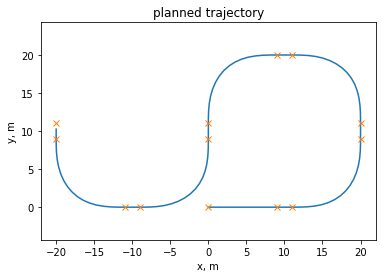

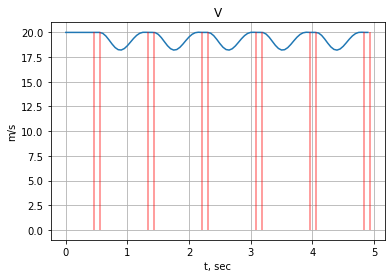

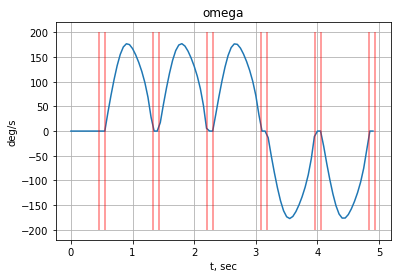

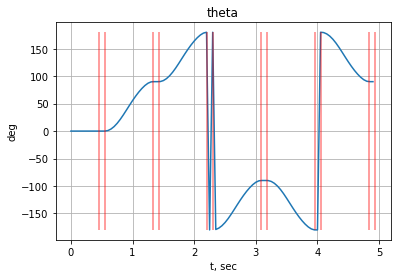

In [10]:
v  = 20
r = 9
planner = RoverPlanner(x=0, y=0, v=v, theta=0, r=r)
# planner.goto(15, 0, v, r)
planner.goto(20, 0, v, r)
# planner.goto(30, 15, v, r)
planner.goto(20, 20, v, r)
planner.goto(0, 20, v, r)
planner.goto(0, 0, v, r)
planner.goto(-20, 0, v, r)
planner.goto(-20, 20, v, r)
# planner.goto(0, 6, v, r)
# planner.goto(0, 12, v, r)
# planner.goto(6, 12, v, r)
# planner.goto(6, 6, v, r)
# planner.goto(-6, 6, v, r)
# planner.goto(-6, 12, v, r)
#planner.stop(-100, 100)

ref_data = planner.compute_ref_data(plot=True)
x_r = ref_data['way_points'][0,:]
y_r = ref_data['way_points'][1,:]
omega = ref_data['omega']
ref_theta = ref_data['theta']    

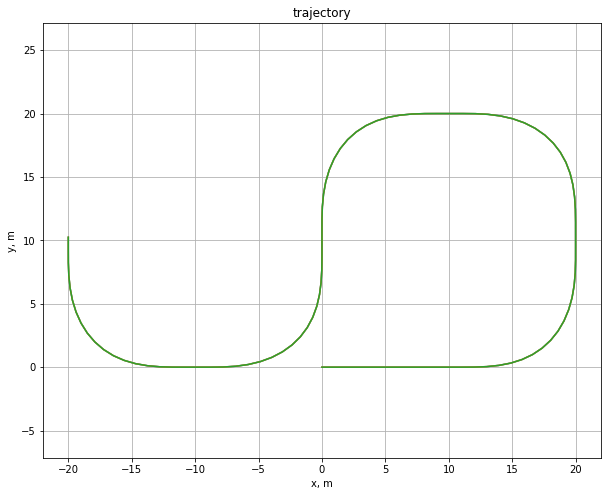

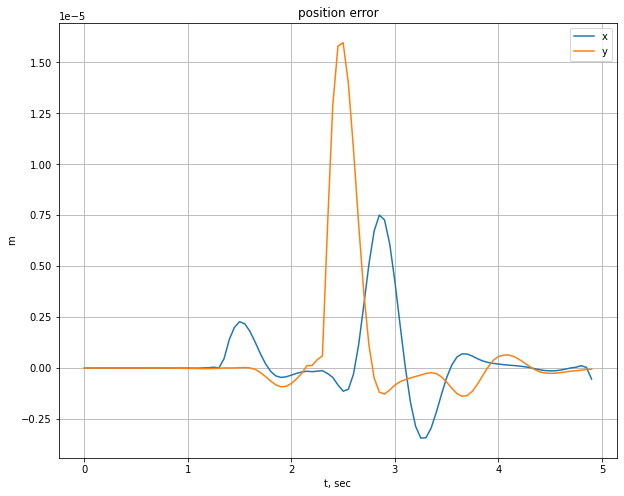

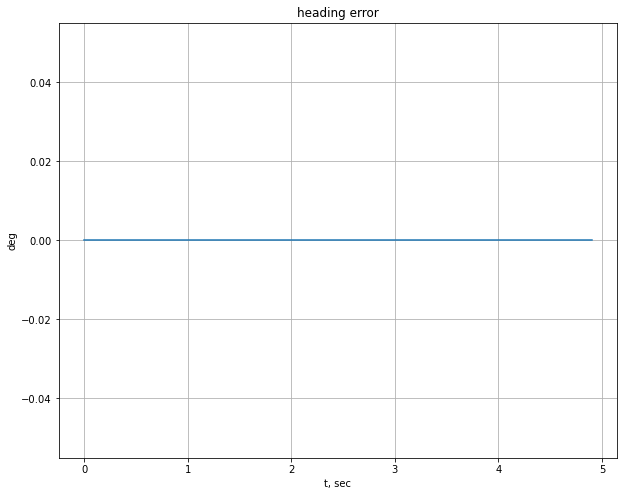

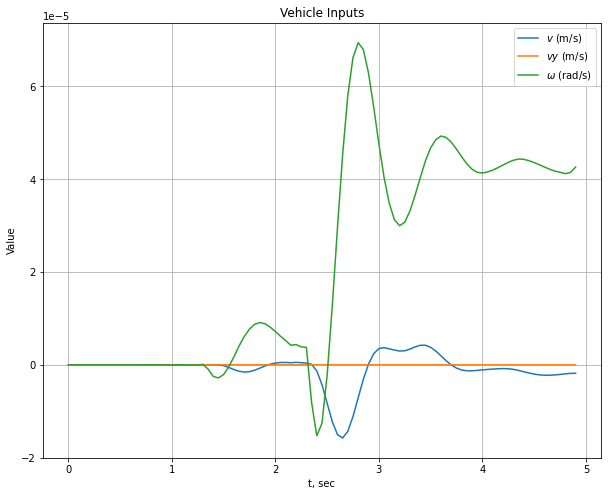

In [31]:
# res = simulate_rover(planner, freq_d=.015, w1=0.1, w2=0.1, x0=0, y0=0, theta0=np.pi/100, dist='sine', dt=.05, use_approx=False)
res = simulate_rover(planner, freq_d=.01, w1=0, w2=0, x0=0, y0=0, theta0=0, dist='square', dt=.05, use_approx=False)
plot_rover_sim(res=res, planner=planner)

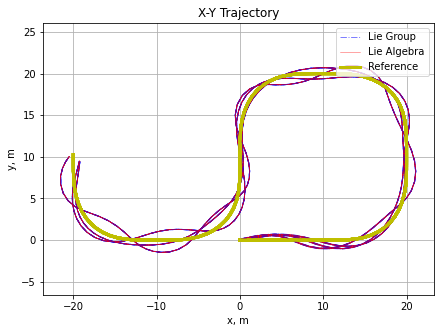

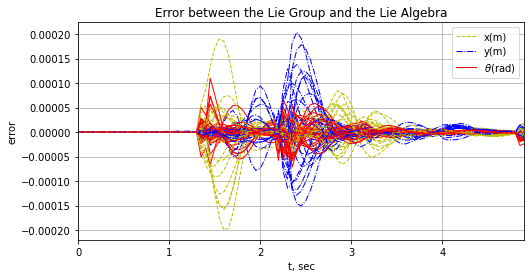

In [34]:
freq = [0.7, 0.9, 1.3]#, .04, .06, .08] # freq = 0.02 not happy with L=diag([1,0,1])
res = []
t = 40
# disturbances
w1 = 5
w2 = .1

cnt = 0
for theta0 in np.linspace(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1, w2, x0, y0, theta0, dist='sine', dt=.05, use_approx = False)
                legend = cnt == 1 and f == freq[-1]
                plot_sim_corres(res, planner, name='', legend=legend, save=False)
                

# Invariant Set

In [22]:
w1 = 5 # small: 1 large: 5 (m/s)
w2 = .1 # small: 0.1 large: .1 (rad/s)
e = np.array([0.1,0.1,np.pi/100]) # Lie Group
e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
t = 0
sol = find_se2_invariant_set(-np.pi, np.pi, 18, 20)
P = sol['P']
beta = (e0.T@P@e0)

In [23]:
w1_new = iteration(w1, w2, beta, t, sol)
points, _ = se2_lie_algebra_invariant_set_points(sol, 10, w1_new, w2, beta) #Lie Algebra
inv_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points = se2(points[0,i], points[1,i], points[2,i]).exp
    inv_points[:,i] = np.array([exp_points.x, exp_points.y, exp_points.theta])

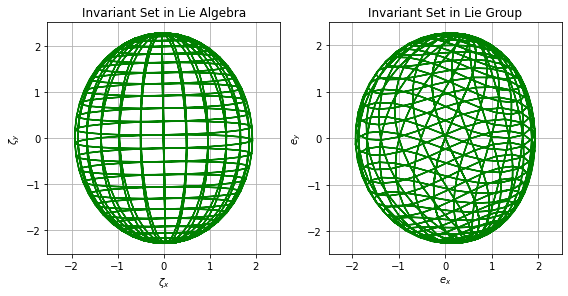

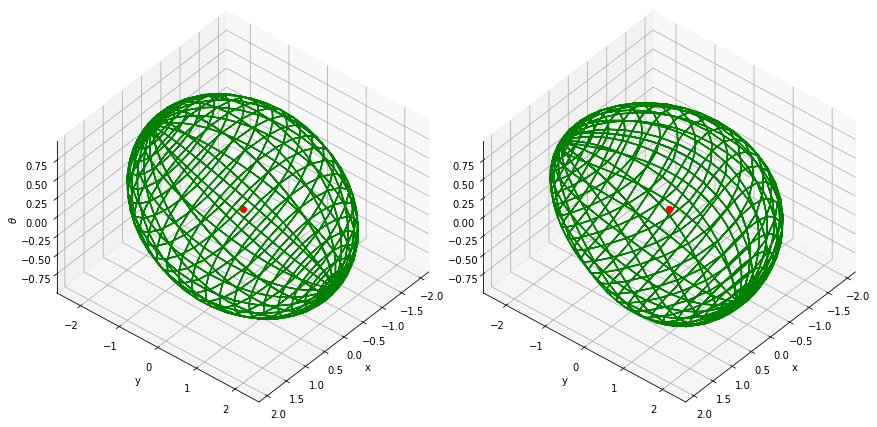

In [24]:
plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(points[0, :], points[1, :], 'g')
ax.set_xlabel('$\\zeta_x$')
ax.set_ylabel('$\\zeta_y$')
# ax.plot(xopt.x,xopt.y,'ro')
plt.axis('equal')
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(inv_points[0, :-1], inv_points[1, :-1], 'g')
# ax2.plot(e[0],e[1],'ro')
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
ax.set_title('Invariant Set in Lie Algebra')
ax2.set_title('Invariant Set in Lie Group')

plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
ax.plot3D(e0[0], e0[1], e0[2], 'ro');
ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\\theta$')
plt.axis('auto')
ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.plot3D(inv_points[0, :], inv_points[1, :], inv_points[2, :], 'g');
ax2.plot3D(e[0], e[1], e[2], 'ro');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.axis('auto')
plt.tight_layout()

In [25]:
def fun(x):
    e = se2(x[0], x[1], x[2])
    return -control_law(B, K, e)[0]

def const(x):
    return x.T@P@x - val

cons = {'type':'eq', 'fun': const}


In [26]:
B, K = solve_control_gain()
P = sol['P']
beta = (e0.T@P@e0)
t = 5
val = np.real(beta*np.exp(-sol['alpha']*t) + (sol['mu1']*w1_new**2 + sol['mu2']*w2**2)*(1-np.exp(-sol['alpha']*t)))
print(val)

7.830941077346279


In [27]:
opt = scipy.optimize.minimize(fun, x0=np.array([-5.2,0,0]), constraints=cons)['x']
xopt = se2(opt[0], opt[1], opt[2])
uopt = control_law(B,K,xopt)
print(uopt)


[ 8.14028696  2.81330205 -5.68513372]


2.272339227007822


Text(0.5, 1.0, 'Invariant Set')

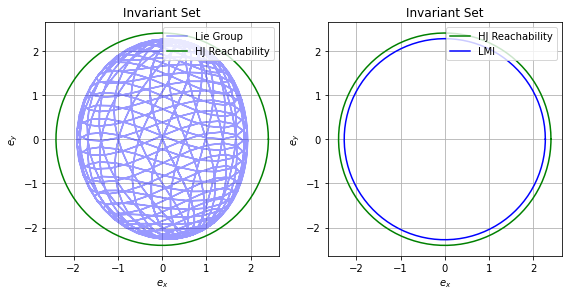

In [28]:
r= 2.4 #0.75 #.2 #1.7
hj_points = hj_invariant_set_points(r)
dist = np.zeros((inv_points.shape[1]))
for i in range(inv_points.shape[1]):
    dist[i] = np.sqrt(inv_points[1,i]**2 + inv_points[0,i]**2)
swept_points = hj_invariant_set_points(dist.max())
print(dist.max())

plt.figure(figsize=(8,4))
ax = plt.subplot(121)
ax.plot(inv_points[0, :], inv_points[1, :], 'b', alpha = 0.4, label='Lie Group');
ax.plot(hj_points[0, :], hj_points[1, :], 'g', label='HJ Reachability');
ax.legend(loc=1)
ax.set_xlabel('$e_x$')
ax.set_ylabel('$e_y$')
# ax.hlines(-1.7, -1.5, 1.5)
#ax.plot(e0[0],e0[1],'ro')
# ax.set_xlim([-3,3])
# ax.set_ylim([-3,3])
plt.grid(True)
ax2 = plt.subplot(122)
ax2.plot(hj_points[0, :], hj_points[1, :], 'g', label='HJ Reachability');
ax2.plot(swept_points[0, :], swept_points[1, :], 'b', label='LMI');
#ax2.plot(e[0],e[1],'ro')
ax2.legend(loc=1)
ax2.set_xlabel('$e_x$')
ax2.set_ylabel('$e_y$')
plt.grid(True)
plt.tight_layout()
ax.set_title('Invariant Set')
ax2.set_title('Invariant Set')

# Flow Pipes Simulation

In [11]:
n = 44# number of interval hulls
# disturbances
w1s = 1
w2s = .1
w1l = 5
w2l = .1
# sol_s = find_se2_invariant_set() # u, v, w1, w2

e0 = SE2(.1, .1, np.pi/100).log.vee

flow_pipes_LMI1, intervalhull_LMI, nom, t_vect, bound_y1, bound_y2 = flowpipes(planner, n, beta, w1s, w2s)


In [12]:
flow_pipes_LMI2, intervalhull_LMI, nom, t_vect, bound_y1l, bound_y2l = flowpipes(planner, n, beta, w1l, w2l)


Text(0, 0.5, 'y')

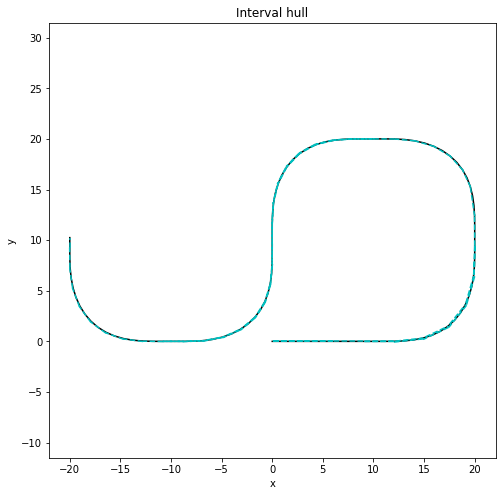

In [41]:
# interval hull
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(44):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')

plt.axis('equal')
plt.title('Interval hull')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

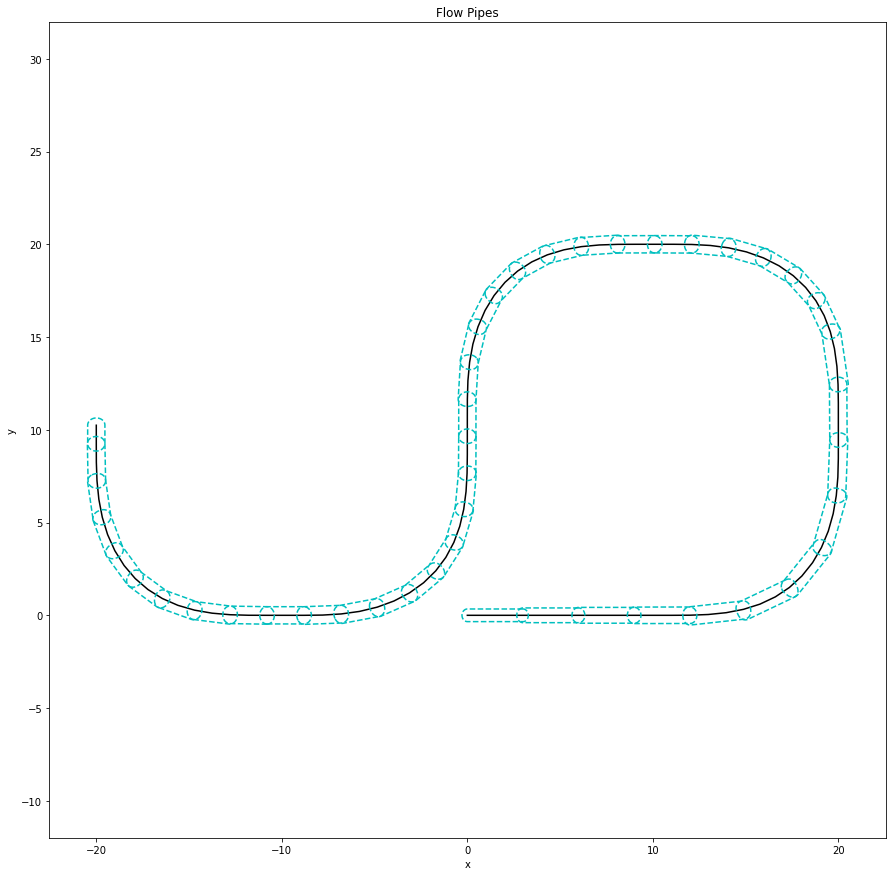

In [42]:
# flow pipes
plt.figure(figsize=(15,15))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

Text(0, 0.5, 'y')

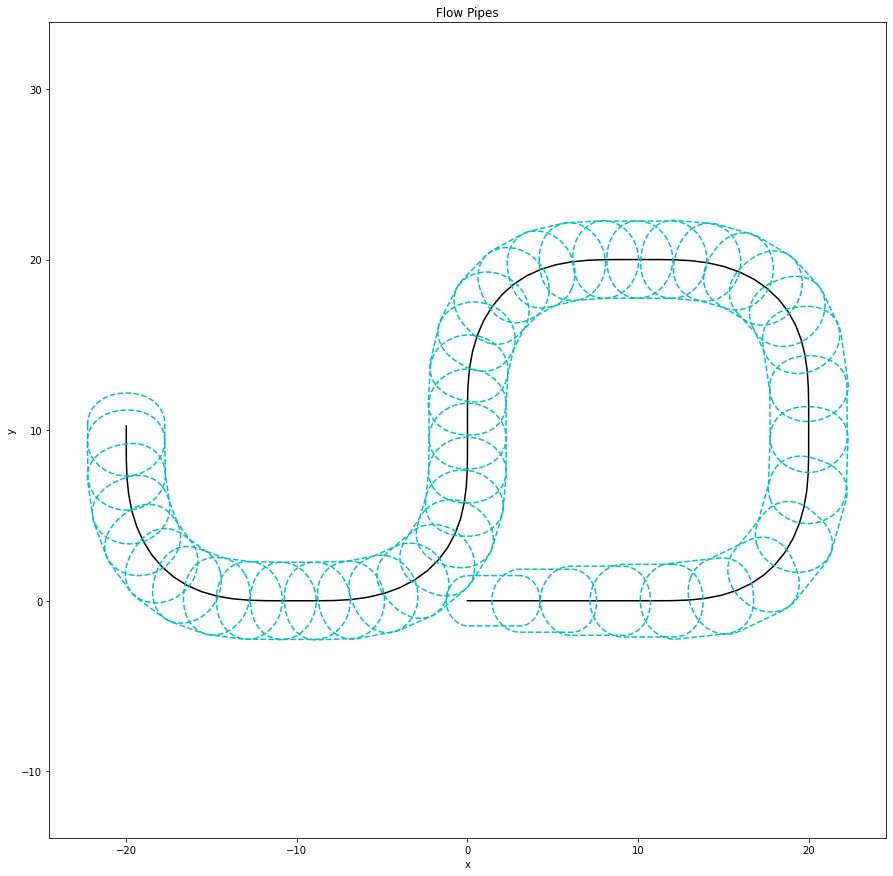

In [43]:
# flow pipes
plt.figure(figsize=(15,15))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI2[facet][:,0], flow_pipes_LMI2[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);


# Trajectories simulation with flow pipe

In [8]:
V2 = np.array([[0, 0], [2, 0], [2, 2], [0, 2]])
P2 = Polytope(V2)
p4 = (17, 8)
P3 = P2*1.5 + (-4,5)
P4 = P2 + p4

P5 = 1.5*P3 - (7, 6.8)


[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


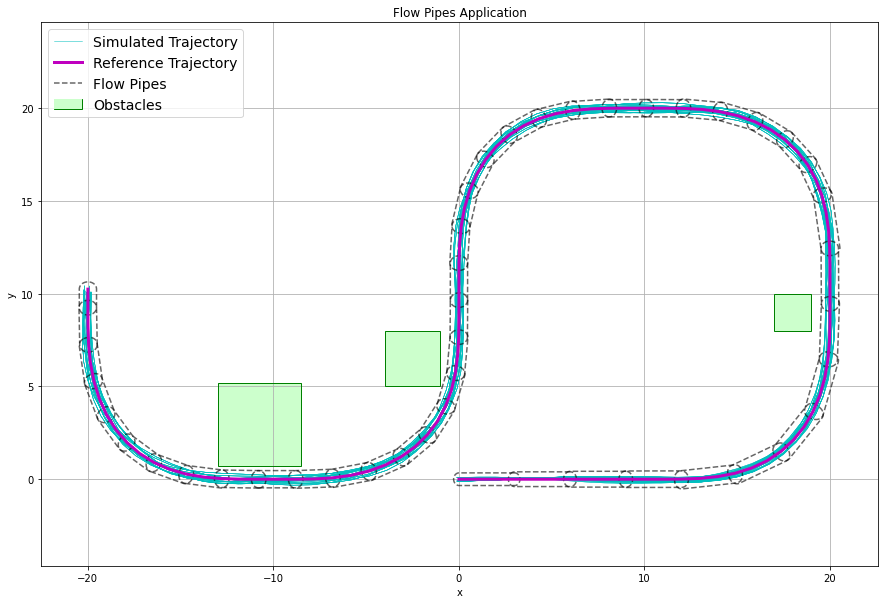

In [29]:
# small distrubance
freq = [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]#, 1.2, 1.3, 1.4, 1.5]#,0.04,0.05
e = []
V = []
# number of interval hulls
# disturbances

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1s, w2s, x0, y0, theta0, dist='sine', dt=0.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1s, w2s, x0, y0, theta0, dist='square', dt=0.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                #if i == len(freq) - 1:
                    #r3 = simulate_rover(planner, f, w1, w2, 0, 0, theta0, dist='maxdV', sol= sol_s)
                    #plot_rover_simulated(r3, name='maxdV', legend= (cnt == 1), save=False, linewidth = 1, color = 'r')

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
# n, flow_pipes_LMI, intervalhull_LMI, nom = flowpipes_traj(planner, res1, x_r, y_r, n, e0, w1, w2)
# n_hull, flow_pipes_hj, intervalhull, nom = flowpipeshj(x_r, y_r, n, e0, w1, w2, 2.4)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI1[facet][:,0], flow_pipes_LMI1[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=2, prop={'size': 14})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[-0.1       ]
 [-0.1       ]
 [-0.03141593]]
[-0.09842098 -0.10156257 -0.03141593]


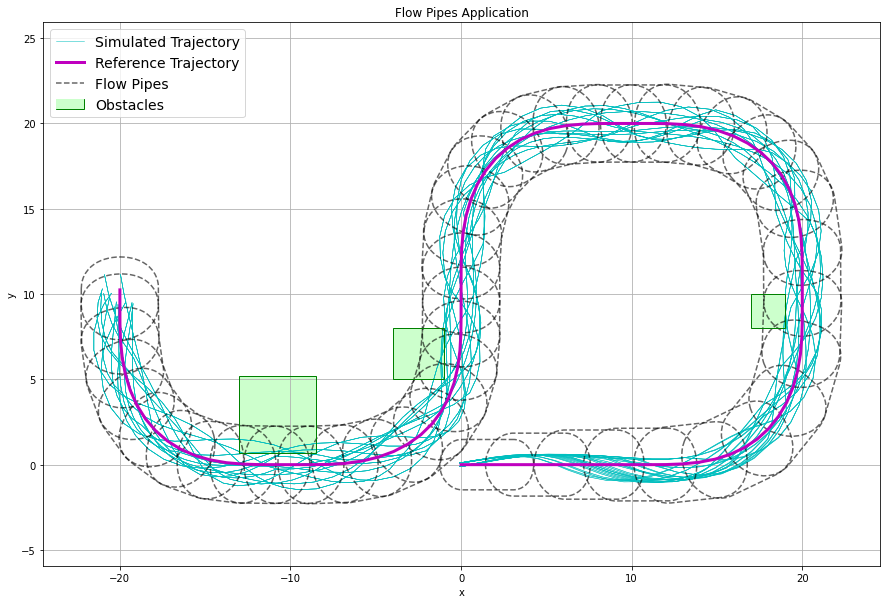

In [30]:
# large distrubance
# 0.04 0.1
freq = [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]#, 0.7, 0.9, 1.1, 1.3, 1.5]#0.04, 0.05, 0.08, 0.09]# [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
e = []
V = []

cnt = 0
for theta0 in np.arange(-np.pi/100, np.pi/100, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                res = simulate_rover(planner, f, w1l, w2l, x0, y0, theta0, dist='sine', dt=.05, use_approx = False)
                res1 = simulate_rover(planner, f, w1l, w2l, x0, y0, theta0, dist='square', dt=.05, use_approx = False)
                legend = cnt == 1 and i == 0
                plot_rover_simulated(res, planner, name='', legend=legend, save=False, linewidth = .5, color = 'c')
                plot_rover_simulated(res1, planner, name=' in square wave', legend=False, save=False, linewidth = .5, color = 'c')
                

i = np.array(V).argmax()
print(e[i])
e0 = SE2(e[i][0], e[i][1], e[i][2]).log.vee
print(e0)
# n_hull, flow_pipes_hj, intervalhull, nom = flowpipeshj(x_r, y_r, n, e0, w1, w2, 0.7)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI2[facet][:,0], flow_pipes_LMI2[facet][:,1], color='k', linestyle='--', alpha = 0.6)

obs = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)

h_nom = plt.plot(nom[:,0], nom[:,1], linewidth = 3, color='m', linestyle='-')
plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=2, prop={'size': 14})
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Reference Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(obs)
labels.append('Obstacles')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

In [ ]:
from multiprocess import Process, Queue

def f(q):
    q.put('hello world')

if __name__ == '__main__':
    q = Queue()
    p = Process(target=f, args=[q])
    p.start()
    print (q.get())
    p.join()

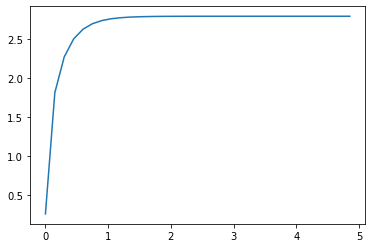

In [18]:
value = []
for t in t_vect:
    val = np.real(beta*np.exp(-sol['alpha']*t) + (sol['mu1']*w1_new**2 + sol['mu2']*.1**2)*(1-np.exp(-sol['alpha']*t)))
    value.append(np.sqrt(val))
plt.plot(t_vect,value)

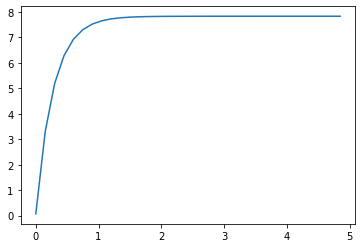

In [19]:
value = []
for t in t_vect:
    val = np.real(beta*np.exp(-sol['alpha']*t) + (sol['mu1']*w1_new**2 + sol['mu2']*w2**2)*(1-np.exp(-sol['alpha']*t)))
    value.append(val)
plt.plot(t_vect,value)

Text(0.5, 1.0, 'Small Disturbance Case')

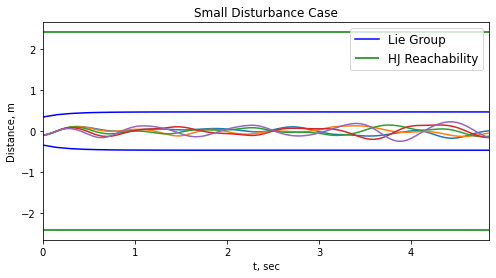

In [67]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9]#, 1.1, 1.3, 1.5]
dist = ['sine']
# t_vect2 = np.linspace(0,t_vect[-1],len(t_vect))
w1s = 1
w2s = .1
# e = np.array([0.1,0.1,np.pi/100]) # Lie Group
# e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra

# omega0 = 0
# R1 = []
# R2 = []
# sol = find_se2_invariant_set(-np.pi/2, np.pi/2)
# zeta = iteration(w1s, w2s, e0, 0, sol)
# v1 = sv1(zeta[2])
# v2 = sv2(zeta[0], zeta[1],zeta[2])
# w1 = v1*w1s + v2*w2s
# w2 = w2s
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1s, w2s, -0.1, -0.1, -np.pi/100, dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_y = err[1,:]
        err_x = err[0,:]
        plt.plot(res['t'], err_y)

plt.plot(t_vect, bound_y1, 'b', label='Lie Group')
plt.plot(t_vect, bound_y2, 'b')
plt.hlines(2.4, 0, t_vect[-1], color='green', label='HJ Reachability')
plt.hlines(-2.4, 0, t_vect[-1], color='green')
plt.legend(loc=1, prop={'size': 12})
plt.xlim(0, t_vect[-1])
plt.xlabel('t, sec')
plt.ylabel('Distance, m')
plt.title('Small Disturbance Case')

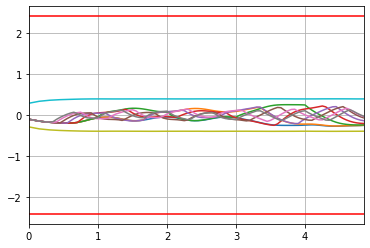

In [266]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]#, 0.03]#3, 0.04, 0.2, 0.02]#, 0.2, 0.7]#, 0.4]#, 0.05, 0.5]#, 0.08, 0.025]#, .02]#, .03]#, .05]#, .05, .07, .09]
dist = ['square']
# t_vect2 = np.linspace(0,t_vect[-1],len(t_vect))
w1s = 1
w2s = .1
# e = np.array([0.1,0.1,np.pi/100]) # Lie Group
# e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
# omega0 = 0
# R = []
# sol = find_se2_invariant_set(-np.pi/2, np.pi/2)
# zeta = iteration(w1s, w2s, e0, 0, sol)
# v1 = sv1(zeta[2])
# v2 = sv2(zeta[0], zeta[1],zeta[2])
# w1 = v1*w1s + v2*w2s
# w2 = w2s
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1s, w2s, -0.1, -0.1, -np.pi/100, dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_x = err[0,:]
        plt.plot(res['t'], err_x)

plt.plot(t_vect, Rx1s)
plt.plot(t_vect, Rx2s)
plt.hlines(2.4, 0, t_vect[-1], color='red')
plt.hlines(-2.4, 0, t_vect[-1], color='red')
plt.xlim(0, t_vect[-1])
plt.grid()
        
# for i in range(len(t_vect)):
#     t = t_vect[i]
#     points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra
#     inv_points = np.zeros((3,points.shape[1]))
#     for j in range(points.shape[1]):
#         exp_points = se2(points[0,j], points[1,j], points[2,j]).exp
#         inv_points[:,j] = np.array([exp_points.x, exp_points.y, exp_points.theta])
#     ang_list = []
#     a = int(t_vect[i]/0.05)
#     if i < 35:
#         b = int(t_vect[i+1]/0.05+1)
#     else:
#         b = int(res['t'][-1]/0.05)
#     for k in range(a, b):
#         angle = ref_theta(0.05*k)
#         ang_list.append(angle)
#     inv_set = [[],[]]
#     for theta in ang_list:
#         inv_set1 = rotate_point(inv_points, theta)
#         inv_set = np.append(inv_set, inv_set1, axis = 1)
#     inv_set = rotate_point(inv_set, -ref_theta(0.05*(a+b)/2))
    
#     max_x = inv_set[0,:].max()
#     min_x = abs(inv_set[0,:].min())
#     x_bound = np.round(min(max_x, min_x),6)
#     R.append(x_bound)
#     omega0 = omega(t)

# plt.plot(t_vect2, R)
# plt.hlines(0.2, 0, 40, color='red')

(0.0, 4.8500000000000005)

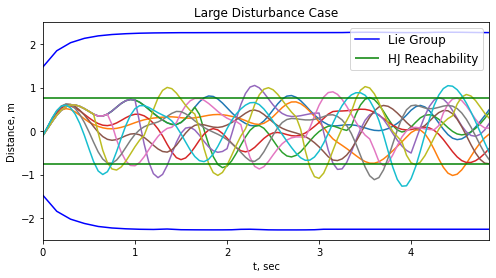

In [66]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9]#, 1.1, 1.3, 1.5]
dist = ['square', 'sine']
# t_vect2 = np.linspace(0,t_vect[-1],len(t_vect))
w1l = 5
w2l = .1
# e = np.array([0.1,0.1,np.pi/100]) # Lie Group
# e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
# omega0 = 0
# R1 = []
# R2 = []
# ly_val = []
# sol = find_se2_invariant_set(-np.pi/2, np.pi/2)
# zeta = iteration(w1l, w2l, e0, 0, sol)
# v1 = sv1(zeta[2])
# v2 = sv2(zeta[0], zeta[1],zeta[2])
# w1 = v1*w1l + v2*w2l
# w2 = w2l
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1l, w2l, -0.1, -0.1, -np.pi/100, dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_y = err[1,:]
        err_x = err[0,:]
        plt.plot(res['t'], err_y)

plt.plot(t_vect,  bound_y1l, 'b')
plt.plot(t_vect,  bound_y2l, 'b', label='Lie Group')
plt.hlines(0.75, 0, t_vect[-1], color='green')
plt.hlines(-0.75, 0, t_vect[-1], color='green', label='HJ Reachability')
plt.legend(loc=1, prop={'size': 12})
plt.xlabel('t, sec')
plt.ylabel('Distance, m')
plt.title('Large Disturbance Case')
plt.xlim(0, t_vect[-1])

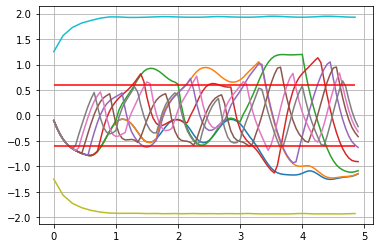

In [268]:
freq = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]#, 0.03]#3, 0.04, 0.2, 0.02]#, 0.2, 0.7]#, 0.4]#, 0.05, 0.5]#, 0.08, 0.025]#, .02]#, .03]#, .05]#, .05, .07, .09]
dist = ['square']
# t_vect2 = np.linspace(0,t_vect[-1],len(t_vect))
w1l = 5
w2l = .1
# e = np.array([0.1,0.1,np.pi/100]) # Lie Group
# e0 = SE2(e[0], e[1], e[2]).log.vee # Lie Algebra
# omega0 = 0
# R2 = []
# ly_val = []
# sol = find_se2_invariant_set(-np.pi/2, np.pi/2)
# zeta = iteration(w1l, w2l, e0, 0, sol)
# v1 = sv1(zeta[2])
# v2 = sv2(zeta[0], zeta[1],zeta[2])
# w1 = v1*w1l + v2*w2l
# w2 = w2l
for i, f in enumerate(freq):
    for d in dist:
        res = simulate_rover(planner, f, w1l, w2l, -0.1, -0.1, -np.pi/100, dist = d, dt=.05, use_approx = False)
        y_vect = res['y']
        x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
        err = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
        err_x = err[0,:]
        plt.plot(res['t'], err_x)

plt.plot(t_vect, Rx1l)
plt.plot(t_vect, Rx2l)
plt.hlines(0.6, 0, t_vect[-1], color='red')
plt.hlines(-0.6, 0, t_vect[-1], color='red')

plt.grid()        

# for i in range(len(t_vect)):
#     t = t_vect[i]
#     points = se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra
#     inv_points = np.zeros((3,points.shape[1]))
#     for j in range(points.shape[1]):
#         exp_points = se2(points[0,j], points[1,j], points[2,j]).exp
#         inv_points[:,j] = np.array([exp_points.x, exp_points.y, exp_points.theta])
#     ang_list = []
#     a = int(t_vect[i]/0.05)
#     if i < 35:
#         b = int(t_vect[i+1]/0.05+1)
#     else:
#         b = int(res['t'][-1]/0.05)
#     for k in range(a, b):
#         angle = ref_theta(0.05*k)
#         ang_list.append(angle)
#     inv_set = [[],[]]
#     for theta in ang_list:
#         inv_set1 = rotate_point(inv_points, theta)
#         inv_set = np.append(inv_set, inv_set1, axis = 1) 
#     set_bound = rotate_point(inv_set, -ref_theta(0.05*(a+b)/2))
    
#     max_x = inv_set[0,:].max()
#     min_x = abs(inv_set[0,:].min())
#     x_bound = np.round(min(max_x, min_x),6)
#     R.append(x_bound)
#     omega0 = omega(t)

# plt.plot(t_vect2, R)
# plt.hlines(1.7, 0, 40, color='red')

In [57]:
res = simulate_rover(planner, 0.05, w1l, w2l, 0.1, 0.1, np.pi/100, dist='square', dt=.05, use_approx = False)

(149, 277, 406, 534, 663)

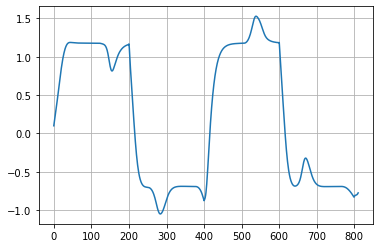

In [82]:
y_vect = res['y']
x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
errLie = np.array([compute_err(y[3], y[4], y[5], y[0], y[1], y[2]) for y in y_vect.T]).T
err_x = x - x_r
err_y = y - y_r
err = np.array([err_x, err_y])
err_rot = rotate_point(err, -theta_r)
plt.plot(err_rot[1,:])
plt.grid()
149, 277, 406, 534, 663

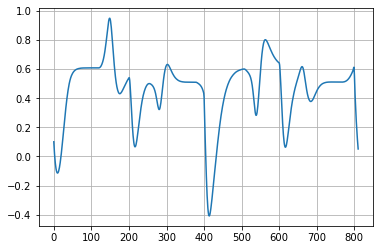

In [87]:
plt.plot(errLie[0,:])
plt.grid()

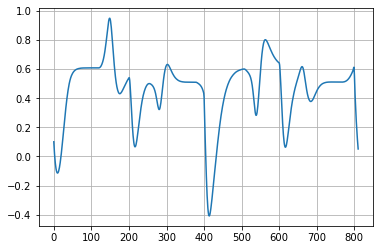

In [85]:
plt.plot(err_rot[0,:])
plt.grid(True)

In [86]:
err_rot[:,406]

array([-0.13847281, -0.71977616])

In [240]:
P = sol['P']
beta = (e0.T@P@e0) # V0
val = np.real(beta*np.exp(-sol['alpha']*t_vect) + (sol['mu1']*w1l**2 + sol['mu2']*w2l**2)*(1-np.exp(-sol['alpha']*t_vect)))

In [49]:
print(err_rot.shape)

(2, 811)
